In [1]:
import os
import sys
import numpy as np
import segmentation_models_pytorch as smp
import segmentation_models_p as sp

import tifffile
import albumentations as A
from matplotlib import pyplot as plt
import skimage.io
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import random
sys.path.append("..") 

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import tqdm

In [2]:
# Ancak şu aşamada unclassified sınıfı da var. 

palette_Aksu ={ 0 : (0,0,0),  #no data AKSUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUU
           1 : (128, 255, 0), #forest
           2 : (166, 0, 204), #mine
           3 : (204, 0, 0), #road
           4 : (255, 0, 0), #disc urban   
           5 : (255, 255, 168), #arable land
           6 : (255,230,166), #heteregonous agricultural areas
           7 : (231, 40, 252), #permenant crops
           8 : (0, 204, 242),  #inland waters
           9 : (255, 166, 255),  #artificial non-agricultural vegetated areas
         }

palette ={ 0 : (0,0,0), #no data KESTELLLLLLLLLLLLLLl
           1 : (231, 40, 252), #permenant crops###
           2 : (204, 0, 0),  #road and rail###
           3 : (255, 255, 168), #arable land ###
           4 : (204, 77, 242),  #idustrial or commercial units
           5 : (0, 204, 242), #inland waters###
           6 : (166, 0, 204), #mine dump and construction sites########
           7 : (128, 255, 0), #forest######
           8 : (255, 166, 255), #artifical and non agricultural veg areas ####
           9 : (204, 242, 77), #shrub and or herbaceous vegetation assucations#####
           10 : (255, 0, 0), #discontinious urban fabric#####
           11 : (255,230,166), #heteregonous agricultural areas###
           12 : (230, 0, 77), #continious urban ####
         }



invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# helper function for data visualization
def visualize_in_one_row(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= (1e-9 + np.max(input) / (max - min + 1e-9))
    input += min
    return input

def show_image(im,target_file): #PCG
      if len(im.shape) == 2:
        im = scale_range(im, 0, 255).astype(np.uint8)
        plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.imshow(im,cmap='gray')
        plt.show()

      elif len(im.shape) == 3:
        im = np.array([scale_range(i, 0, 255) for i in im.transpose((2,0,1))]).transpose(1,2,0)[...,:3].astype(np.uint8)
        plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.savefig(target_file, format = 'png', dpi =80,  transparent = True, bbox_inches = 'tight', pad_inches = 0)
        plt.imshow(im)
        plt.show()

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def evaluate(model, generator):
    """ usage:
        from sklearn.metrics import classification_report
        y_pred, y = evaluate(best_model, generator)
        y_pred  = np.hstack(y_pred)
        y = np.hstack(y)
        targets = ['building', 'not_building']
        print(classification_report(y, y_pred, target_names = targets))#, output_dict = True)
    """
    
    best_model = model
    best_model.cuda()
    best_model.eval()

    y_preds = list()
    ys = list()
    with torch.no_grad():
        for idx in tqdm.tqdm(range(len(generator))):
            X,y = generator[idx]
            #X = X.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            gt_max = np.argmax(y, axis=0)
            #gt_colora = convert_to_color(gt_max)
            logsoftmax = best_model.forward(X[None,:,:])
            y_pred = logsoftmax.argmax(dim=1)
            y_pred = y_pred.squeeze()
            gt_color = torch.as_tensor(gt_max).cuda()
            gt_color = gt_color.detach().cpu().numpy().flatten()
            y= gt_color 
            y_pred = y_pred.flatten().detach().cpu().numpy()
            
            ys.append(y)
            y_preds.append(y_pred)
            
    best_model.cpu()
    return y_preds, ys    
    
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    out = torch.utils.data.dataloader.default_collate(batch)
    print("len batch",len(out))
    return out

Class_names_a = ['NoData',
               'Forest',
               'Mine, dump and construction sites',
                'Road and Rail',
                'Discontinious Urban Fabric',
               'Arable Land',
               'Heterogeneous agricultural areas',
                'Permenant Crops',
                'Inland Waters',
                'Artificial, non-agricultural vegetated areas'] 

Class_names = ['NoData',
          'Permanent crops',
           'Road and Rail',
           'Arable Land',
            'Industrial or commercial units',
            'Inland waters',
             'Mine dump and construction sites',
            'Forest',
            'Artificial and non agricultural veg areas',
            'Shrub and/or herbaceous vegetation associations',
             'Discontinious urban fabric',
             'Heteregonous agricultural areas',
             'Continious urban fabric'
               ] 

## aksu

In [ ]:
log_path = r"C:\Users\CBS-7\Desktop\KOC_LCLU\Aksu\Experiments"
experiment_log = 'aksu_3__dice_focal_imagenet_YESsample_nonormalize_Newpalettte'

## kestel

In [ ]:
log_path = r"C:\Users\CBS-7\Desktop\KOC_LCLU\Kestel\Experiments"
experiment_log = 'kestel_dice_focal_imagenet_YESsample_nonormalize_new_palette'

## kestel + aksu

In [3]:
log_path = r"C:\Users\CBS-7\Desktop\KOC_LCLU\Kestel\Experiments"
experiment_log = 'aksu+kestel_dice_focal_imagenet_YESsample_nonormalize_new_palette'

## infernece

In [4]:
best_model = torch.load(os.path.join(log_path, '.\{}.pth'.format(experiment_log)))
best_model.cpu()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [5]:
def _read_img(image_path):
        img = skimage.io.imread(image_path, plugin='tifffile')
        return img

In [6]:
soganli_path = r"C:\Users\CBS-7\Desktop\WV-3\WV-3\unclassified_image\Soganli_image_wv03.tif"

In [7]:
soganli = _read_img(soganli_path)

In [8]:
soganli_crop = soganli[0:5376,0:5376,:]

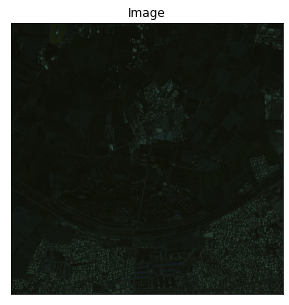

In [9]:
visualize_in_one_row(Image = scale_range(soganli_crop.astype('float'), 0, 255)[...,:3].astype(np.uint8))


In [10]:
soganli_crop.shape

(5376, 5376, 4)

In [11]:
soganli_ = soganli_crop.transpose(2, 0, 1).astype('float32') 

In [12]:
soganli_b = torch.unsqueeze(torch.as_tensor(soganli_, dtype = torch.float32), dim = 0)

In [13]:
soganli_b.shape

torch.Size([1, 4, 5376, 5376])

In [14]:
torch.backends.cudnn.benchmark=False

In [15]:
pr_mask = best_model.predict(soganli_b).detach().cpu().numpy()

C:\Users\CBS-7\anaconda3\envs\pgpu\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [16]:
pr_mask.shape

(1, 13, 5376, 5376)

In [17]:
pr_max = np.argmax(pr_mask, 1)

In [18]:
pr_max = np.transpose(pr_max, (1,2,0)).squeeze()

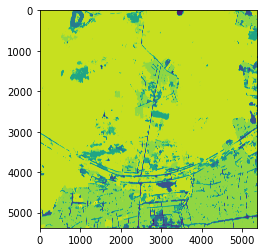

In [19]:
plt.imshow(pr_max)

In [20]:
pr_max.shape

(5376, 5376)

In [21]:
skimage.io.imsave(r'C:\Users\CBS-7\Desktop\outputs\soganli_classified_by_aksu_and_kestel_output_DECODED.tif',pr_max)

<ipython-input-21-9ef880d79482>:1: UserWarning: C:\Users\CBS-7\Desktop\outputs\soganli_classified_by_aksu_and_kestel_output_DECODED.tif is a low contrast image
  skimage.io.imsave(r'C:\Users\CBS-7\Desktop\outputs\soganli_classified_by_aksu_and_kestel_output_DECODED.tif',pr_max)


In [22]:
pr_max11 = convert_to_color(pr_max)

In [23]:
pr_max11.shape

(5376, 5376, 3)

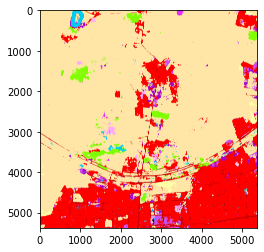

In [24]:
plt.imshow(pr_max11)

In [ ]:
uniques, counts = np.unique(pr_max, return_counts=True)

In [ ]:
uniques, counts

In [ ]:
plt.scatter(uniques,counts)

In [ ]:
skimage.io.imsave(r'C:\Users\CBS-7\Desktop\KOC_LCLU\soganli\soganli_classified_by_kestel_AND_aksu_output_new_palette.tif',pr_max11 )

In [29]:
from osgeo import osr, gdal

def _read_img(image_path):
        img = skimage.io.imread(image_path, plugin='tifffile')
        return img

kestel_dir = r"C:\Users\CBS-7\Desktop\outputs\soganli_classified_by_kestel_output_DECODED.tif"
aksu_dir = r"C:\Users\CBS-7\Desktop\outputs\soganli_classified_by_aksu_output_DECODED.tif"
kestel_and_aksu_dir = r"C:\Users\CBS-7\Desktop\outputs\soganli_classified_by_aksu_and_kestel_output_DECODED.tif"

out_path = r"C:\Users\CBS-7\Desktop\outputs\soganli_classified_by_aksu_and_kestel_output_DECODED_GEOREFERENCED.tif"

source_image_Dir = r"C:\Users\CBS-7\Desktop\WV-3\WV-3\unclassified_image\Soganli_image_wv03.tif"



width = 5376 #5376, 5376, 3
height = 5376
ds = gdal.Open(source_image_Dir)
tfw = ds.GetGeoTransform()
prj = ds.GetProjection()
srs = osr.SpatialReference(wkt=prj)
driver = gdal.GetDriverByName("GTiff")

mask = _read_img(kestel_and_aksu_dir)

outdata = driver.Create(out_path, height, width, 1, gdal.GDT_Byte)
outdata.SetGeoTransform(tfw)##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(mask)

outdata.FlushCache() ##saves to disk!!
outdata = None
ds=None

### kestel

In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import skimage.io

In [ ]:
# Ancak şu aşamada unclassified sınıfı da var. 

### KESTEL PALETİ AMA AKSU RENKLERİYLE 

palette ={ 0 : (0,0,0),         #no data ##########-------------------
           1 : (231, 40, 252), #permenant crops ###########-------------------
           2 : (16,97,227),   #road and rail ###########------------------
           3 : (66,79,2),   #arable land ##########----------------
           4 : (59, 125, 1),  #industrial or commercial units  +++++++++++++++++++++++++++++++ AKSUDA YOK
           5 : (230, 32, 18),#ınland waters ###########3---------------
           6 : (252,212,10), #mine dump and constructino sites ############-----------------
           7 : (3, 171, 109), #forst ######-------------------- 
           8 : (39,33,51),  #artificial non agricultural vegetated areas ##########------------
           9 : (51, 245, 17), # shrub and or herbaceous vegetation associations +++++++++++++++++++++++++++++++ AKSUDA YOK
           10 : (189, 6, 94),#discontinious urban fabric ############--------------
           11 : (237, 242, 208),# heteregonous agricultural areas ############---------------- 
           12 : (31, 161, 137), # continious urban fabric +++++++++++++++++++++++++++++++ AKSUDA YOK
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# helper function for data visualization
def visualize_in_one_row(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= (1e-9 + np.max(input) / (max - min + 1e-9))
    input += min
    return input

def show_image(im,target_file): #PCG
      if len(im.shape) == 2:
        im = scale_range(im, 0, 255).astype(np.uint8)
        plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.imshow(im,cmap='gray')
        plt.show()

      elif len(im.shape) == 3:
        im = np.array([scale_range(i, 0, 255) for i in im.transpose((2,0,1))]).transpose(1,2,0)[...,:3].astype(np.uint8)
        plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.savefig(target_file, format = 'png', dpi =80,  transparent = True, bbox_inches = 'tight', pad_inches = 0)
        plt.imshow(im)
        plt.show()
        
Class_names = ['1',
               '2',
               '3',
                '4',
                '5',
               '6',
               '7',
                '8',
                '9',
                 '10',
                '11',
                 '12',
                  '13']

In [ ]:
path = r"C:\Users\CBS-7\Desktop\KOC_LCLU\Kestel\Experiments\kestel_dice_focal_imagenet_YESsample_nonormalize.pth"

In [ ]:
best_model = torch.load(path)
best_model.cpu()

In [ ]:
    def _read_img(image_path):
        img = skimage.io.imread(image_path, plugin='tifffile')
        return img

In [ ]:
soganli_path = r"C:\Users\CBS-7\Desktop\WV-3\WV-3\unclassified image\Soganli_image_wv03.tif"

In [ ]:
soganli = _read_img(soganli_path)

In [ ]:
soganli.shape

In [ ]:
soganli_crop = soganli[0:5376,0:5376,:]

In [ ]:
visualize_in_one_row(Image = scale_range(soganli_crop.astype('float'), 0, 255)[...,:3].astype(np.uint8))


In [ ]:
soganli_crop.shape

In [ ]:
soganli_ = soganli_crop.transpose(2, 0, 1).astype('float32') 

In [ ]:
soganli_b = torch.unsqueeze(torch.as_tensor(soganli_, dtype = torch.float32), dim = 0)

In [ ]:
soganli_b.shape

In [ ]:
torch.backends.cudnn.benchmark=False

In [ ]:
pr_mask = best_model.predict(soganli_b).detach().cpu().numpy()


In [ ]:
pr_mask.shape

In [ ]:
pr_max = np.argmax(pr_mask, 1)

In [ ]:
pr_max = np.transpose(pr_max, (1,2,0)).squeeze()

In [ ]:
pr_max11 = convert_to_color(pr_max)

In [ ]:
pr_max11.shape

In [ ]:
plt.imshow(pr_max11)

In [ ]:
uniques, counts = np.unique(pr_max, return_counts=True)

In [ ]:
uniques, counts

In [ ]:
skimage.io.imsave(r'C:\Users\CBS-7\Desktop\KOC_LCLU\soganli\kestel\soganli_2_forkestel_output.png',pr_max11 )

In [ ]:
plt.scatter(uniques,counts)

In [ ]:
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import skimage.io
import torch
from skimage import io
from osgeo import osr, gdal
import tifffile
import torch.nn as nn
import cv2 
from skimage.restoration import denoise_bilateral
from matplotlib import pyplot as plt


def scale_range(input, min, max):
    input += -(np.min(input))
    input /= (1e-9 + np.max(input) / (max - min + 1e-9))
    input += min
    return input

class MM_Dataset(Dataset):  
    
    def __init__(
            self, 
            train_dir,
            transform = None):
        
        self.train_dir = train_dir
        self.transform = transform
           
        optic_dir = self.train_dir
            
        self.optic_ids = os.listdir(optic_dir)
        
        self.optic_fps = [os.path.join(optic_dir, image_id) for image_id in self.optic_ids]
        
        print("Set: {} image".format(len(self.optic_ids)))


    @staticmethod
    def _read_img(image_path):
        img = skimage.io.imread(image_path, plugin='tifffile')
        return img

    def __len__(self):
        return len(self.optic_ids)
    
    def __getitem__(self, idx):
                 
        optic_id = self.optic_fps[idx].split('\\')[-1]
        optic_filepath = self.optic_fps[idx]
        
        image = self._read_img(optic_filepath)
        
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
            
        image = image.transpose(2, 0, 1).astype('float32')
        
        image = torch.as_tensor(image, dtype=torch.float32).cuda()

            
        return image, optic_id

In [ ]:
palette ={ 0 : (0,0,0), #no data
           1 : (231, 40, 252), #permenant crops###
           2 : (204, 0, 0),  #road and rail###
           3 : (255, 255, 168), #arable land ###
           4 : (204, 77, 242),  #idustrial or commercial units
           5 : (0, 204, 242), #inland waters###
           6 : (166, 0, 204), #mine dump and construction sites########
           7 : (128, 255, 0), #forest######
           8 : (255, 166, 255), #artifical and non agricultural veg areas ####
           9 : (204, 242, 77), #shrub and or herbaceous vegetation assucations#####
           10 : (255, 0, 0), #discontinious urban fabric#####
           11 : (255,230,166), #heteregonous agricultural areas###
           12 : (230, 0, 77), #continious urban ####
         }

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

import albumentations as A

inference_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=512, min_width=512)
                      ])

In [ ]:
log_path = r"C:\Users\CBS-7\Desktop\KOC_LCLU\Kestel\Experiments"
experiment_log = 'aksu+kestel_dice_focal_imagenet_YESsample_nonormalize_new_palette'

best_model = torch.load(os.path.join(log_path, '.\{}.pth'.format(experiment_log)))
best_model.cuda()

In [ ]:
inference_dataset_geo = MM_Dataset(train_dir = r"C:\Users\CBS-7\Desktop\KOC_LCLU\soganli\Patches\tif", transform = inference_transform)

In [ ]:
for i in range(len(inference_dataset_geo)):
        
    image = np.transpose(inference_dataset_geo[i][0].detach().cpu().numpy(),(1,2,0))
    viz_im = np.array([scale_range(i, 0, 255) for i in image.transpose((2,0,1))]).transpose(1,2,0)[...,:3].astype(np.uint8)
    
    x_tensor= inference_dataset_geo[i][0]
    tensor = torch.unsqueeze(torch.tensor(x_tensor), axis = 0)
    tensor = tensor.float() 
    tensor = torch.tensor(tensor, device = 'cuda')
    pr_mask = best_model.cuda().predict(tensor).detach().cpu().numpy()
    pr_max  = np.argmax(pr_mask, 1)
    pr_max = np.transpose(pr_max, (1,2,0)).squeeze()
    pr_max11 = convert_to_color(pr_max)
    
    image_dir = inference_dataset_geo[i][-1]
    aa_dir  = os.path.join(r"C:\Users\CBS-7\Desktop\KOC_LCLU\soganli\Patches\tif", image_dir)
    ds = gdal.Open(aa_dir)
    im = tifffile.imread(aa_dir)
    width = pr_max11.shape[1]
    height = pr_max11.shape[0]
    
    plt.imshow(pr_max11)
    
    tfw = ds.GetGeoTransform()
    prj = ds.GetProjection()
    srs = osr.SpatialReference(wkt=prj)
    driver = gdal.GetDriverByName("GTiff")
    out_path1 = r"C:\Users\CBS-7\Desktop\KOC_LCLU\soganli\Patch_Predictions_w_GEO"
    
    out_p = os.path.join(out_path1, os.path.split(image_dir)[-1])
    outdata = driver.Create(out_p, height, width, 3, gdal.GDT_Byte)
    
    outdata.SetGeoTransform(tfw)##sets same geotransform as input
    outdata.SetProjection(ds.GetProjection())##sets same projection as input
    outdata.GetRasterBand(1).WriteArray(pr_max11[:,:,0])
    outdata.GetRasterBand(2).WriteArray(pr_max11[:,:,1])
    outdata.GetRasterBand(3).WriteArray(pr_max11[:,:,2])

    outdata.FlushCache()
    outdata = None
    ds=None